# 필요한 모듈 설치

In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 21.68 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 57.2 MB/s 
     |████████████████████████████████| 465 kB 56.7 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-11-26 03:58:04--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (

In [4]:
import pickle
import numpy as np
import io
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 파일 로드 & 전처리

In [73]:
total_data = pd.read_csv("/content/drive/MyDrive/캡스톤/VP_dataset.csv",delimiter=',')
total_data = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),delimiter=',')
print('전체 리뷰 개수 :',len(total_data))
print(total_data[:5])
print(total_data.shape)
# 각 열에 대해서 중복을 제외한 샘플의 수를 카운트
total_data['대화'].nunique(), total_data['VP 여부'].nunique()

전체 리뷰 개수 : 500
                                                  대화  VP 여부
0  반갑습니다 상담사 땡땡땡입니다 예 수고하십니다 저 세탁기가 작동이 안 돼요 작동이 ...      0
1  오늘도 가능합니다 시간은 언제쯤 괜찮으세여 가장 빠른시간이 오늘 오전 열한시 괜찮으...      0
2  아까 전화했던 땡땡땡인데요 바로 전화주신다 했는데 전화가 안 와서요 고객님 저희가 ...      0
3  반갑습니다 상담사 땡땡땡입니다 티비를 일 월 십 몇 일 날인가 구입을 했는데요 화면...      0
4  반갑습니다 상담사 땡땡땡입니다 네 저 에어컨 작동이 안돼서 상담 좀 하고싶은데요 저...      0
(500, 2)


(500, 2)

In [74]:
# NULL 값 유무를 확인
print(total_data.isnull().values.any()) 

False


In [75]:
# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 375
테스트용 리뷰의 개수 : 125


In [76]:
# 훈련/테스트 데이터의 레이블의 분포
print(train_data.groupby('VP 여부').size().reset_index(name = 'count'))
print(test_data.groupby('VP 여부').size().reset_index(name = 'count'))

   VP 여부  count
0      0    189
1      1    186
   VP 여부  count
0      0     61
1      1     64


#데이터 정제하기

In [77]:
# 정규 표현식을 사용하여 한글을 제외하고 모두 제거
# 혹시 이 과정에서 빈 샘플이 생기지는 않는지 확인
# 한글과 공백을 제외하고 모두 제거
train_data['대화'] = train_data['대화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['대화'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

대화       0
VP 여부    0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [78]:
test_data.drop_duplicates(subset = ['대화'], inplace=True) # 중복 제거
test_data['대화'] = test_data['대화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['대화'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [79]:
# 불용어를 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']
tmp = ['히히', '땡땡땡', '땡땡', '땡']
stopwords = stopwords + tmp
print(stopwords)

['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면', '히히', '땡땡땡', '땡땡', '땡']


In [80]:
# 형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행
mecab = Mecab() 

train_data['tokenized'] = train_data['대화'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['대화'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [81]:
# 단어와 길이 분포 계산 후 리스트로 저장
nonVP_words = np.hstack(train_data[train_data['VP 여부'] == 0]['tokenized'].values)
VP_words = np.hstack(train_data[train_data['VP 여부'] == 1]['tokenized'].values)

In [82]:
# Counter()를 사용하여 각 단어에 대한 빈도수를 카운트 후 상위 20개 단어 출력
nonVP_words_count = Counter(nonVP_words)
print(nonVP_words_count.most_common(20))

VP_words_count = Counter(VP_words)
print(VP_words_count.most_common(20))

[('시', 344), ('님', 303), ('습니다', 301), ('고객', 257), ('있', 252), ('해', 225), ('겠', 220), ('요', 212), ('세요', 197), ('안', 179), ('예', 175), ('거', 172), ('전화', 155), ('주', 153), ('나', 146), ('입니다', 123), ('어', 123), ('확인', 122), ('기사', 115), ('합니다', 113)]
[('시', 372), ('있', 283), ('본인', 213), ('거', 210), ('저희', 209), ('으로', 209), ('에서', 177), ('통장', 139), ('해', 139), ('님', 138), ('지금', 136), ('그', 125), ('로', 124), ('받', 114), ('주', 112), ('은행', 108), ('어', 105), ('고객', 105), ('신', 104), ('적', 98)]


In [83]:
# label / 데이터 나누기
X_train = train_data['tokenized'].values
y_train = train_data['VP 여부'].values
X_test= test_data['tokenized'].values
y_test = test_data['VP 여부'].values

# 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다

In [84]:
# 훈련 데이터에 대해서 단어 집합(vocaburary) 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [85]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3484
등장 빈도가 1번 이하인 희귀 단어의 수: 1571
단어 집합에서 희귀 단어의 비율: 45.091848450057405
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.73820726263723


In [86]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1915


In [87]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

import pickle
with open('/content/drive/MyDrive/캡스톤/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

대화의 최대 길이 : 283
대화의 평균 길이 : 88.416


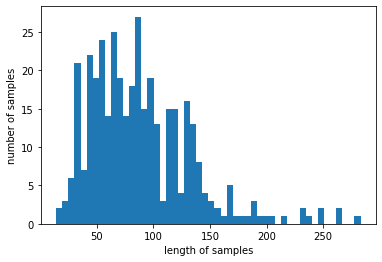

In [88]:
print('대화의 최대 길이 :',max(len(sample) for sample in X_train))
print('대화의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [89]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 200
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 200 이하인 샘플의 비율: 97.33333333333334


In [90]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
with open('/content/drive/MyDrive/캡스톤/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

Epoch 1/32
1/2 [==============>...............] - ETA: 3s - loss: 0.6933 - accuracy: 0.5039
Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to /content/drive/MyDrive/캡스톤/best_model.h5
2/2 [==============================] - 4s 1s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.4667
Epoch 2/32
1/2 [==============>...............] - ETA: 0s - loss: 0.6889 - accuracy: 0.5234
Epoch 2: val_accuracy improved from 0.46667 to 0.62667, saving model to /content/drive/MyDrive/캡스톤/best_model.h5
2/2 [==============================] - 0s 133ms/step - loss: 0.6887 - accuracy: 0.5600 - val_loss: 0.6848 - val_accuracy: 0.6267
Epoch 3/32
1/2 [==============>...............] - ETA: 0s - loss: 0.6846 - accuracy: 0.5820
Epoch 3: val_accuracy did not improve from 0.62667
2/2 [==============================] - 0s 63ms/step - loss: 0.6834 - accuracy: 0.6000 - val_loss: 0.6766 - val_accuracy: 0.6133
Epoch 4/32
1/2 [==============>...............] - ETA: 0s

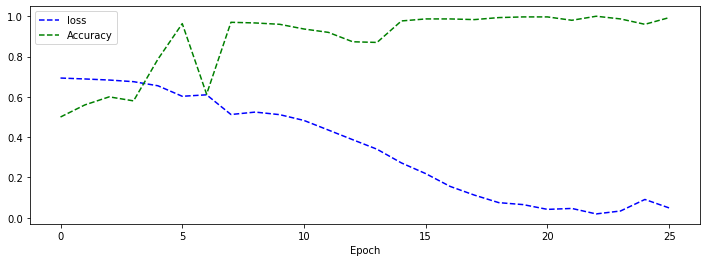

최적화 완료!


In [91]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

save_model = '/content/drive/MyDrive/캡스톤/best_model.h5'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(save_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=32, callbacks=[es, mc], batch_size=256, validation_split=0.2)

plt.figure(figsize = (12,4)) # 그래프 가로세로 비율 (그림(figure)의 크기, (가로, 세로) 인치 단위)
plt.subplot(1,1,1) # 1행 1열 첫 번째 위치
plt.plot(history.history['loss'], 'b--', label = 'loss') # loss 파란색 점선
plt.plot(history.history['accuracy'], 'g--', label = 'Accuracy') # accuracy 는 녹색실선
plt.xlabel('Epoch')
plt.legend()
plt.show()
print('최적화 완료!')

In [92]:
print("\n============test results============")
loaded_model = load_model(save_model)
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


============test results============
4/4 [==============================] - 1s 10ms/step - loss: 0.2651 - accuracy: 0.9200
테스트 정확도: 0.9200


In [93]:
def sentiment_predict(new_sentence):
  new_sentence_data = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence_data = mecab.morphs(new_sentence_data) # 토큰화
  new_sentence_data = [word for word in new_sentence_data if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence_data]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(new_sentence)
  score = float(loaded_model.predict(pad_new, verbose=0)) # 예측
  print("="*40)
  print("=>보이스피싱일 확률 {:.2f}%".format(score * 100))
  if(score > 0.6):
    print("판별 결과 : 보이스피싱입니다.")
  else:
    print("판별 결과 : 보이스피싱이 아닙니다.")
  print()
  print("-"*40)

# VP o
sentiment_predict('본인이 직접 움직일 필요 없으시고요 그냥 그 통장 안에 잔고없는 통장과 연결된 현금카드 갖고 계시는 거 있죠?\n네\n그냥 그 현금인출카드만 저희쪽으로 한 달 동안 빌려주시는 거에요')
sentiment_predict('어 저는 금융범죄 수사 1팀장을 맡고 있는 신승용 검사라고 합니다.\n메모하세요 자 명의 도용 사건 내용 이해하셨나요?\n자 그럼 이 사건에 대해서는 지금 본인 사건이기 때문에 본인께서 구체적으로 알 권리가 있습니다.\n따라서 본 검사는 이번 사건에 대해서 구체적으로 설명을 해드릴 건데 설명 도중에 이해 못하시는 부분이 있으면 질문해 주시기 바랍니다.\n음 저희 검찰은 김혜선 외 공범 8명 금융범죄 사기단을 검거했습니다.')
sentiment_predict('면허증 뭐 여권 같은 것도 전혀 없으신 거죠? 재발급 받아 보신 적도 한번도 없으신 거고.')

# VP x
sentiment_predict('A : 저번에 빌린 10만원 언제 갚을거야?\nB : 까먹고 있었네.\n계좌번호 불러줘 지금 바로 송금할께\nA : 국민은행 ***…\nB : 송금했어. 다음번에 내가 밥 한번 살께')
sentiment_predict('반갑습니다 상담사 땡땡땡입니다\n예 수고하십니다 저 세탁기가 작동이 안 돼요\n작동이 안 된다면은 뭐 전원은 들어오는데 회전만 안 되는 거에여\n네 전원은 들어와요\n많이 답답하셨겠습니다 고객님 저희 세탁기가 일반 통세탁기세여 드럼세탁기세여\n예 드럼 세탁기여\n드럼이구 혹시 사용하신 지는 일 년이 지나셨어여')

본인이 직접 움직일 필요 없으시고요 그냥 그 통장 안에 잔고없는 통장과 연결된 현금카드 갖고 계시는 거 있죠?
네
그냥 그 현금인출카드만 저희쪽으로 한 달 동안 빌려주시는 거에요
=>보이스피싱일 확률 91.70%
판별 결과 : 보이스피싱입니다.

----------------------------------------
어 저는 금융범죄 수사 1팀장을 맡고 있는 신승용 검사라고 합니다.
메모하세요 자 명의 도용 사건 내용 이해하셨나요?
자 그럼 이 사건에 대해서는 지금 본인 사건이기 때문에 본인께서 구체적으로 알 권리가 있습니다.
따라서 본 검사는 이번 사건에 대해서 구체적으로 설명을 해드릴 건데 설명 도중에 이해 못하시는 부분이 있으면 질문해 주시기 바랍니다.
음 저희 검찰은 김혜선 외 공범 8명 금융범죄 사기단을 검거했습니다.
=>보이스피싱일 확률 94.96%
판별 결과 : 보이스피싱입니다.

----------------------------------------
면허증 뭐 여권 같은 것도 전혀 없으신 거죠? 재발급 받아 보신 적도 한번도 없으신 거고.
=>보이스피싱일 확률 88.91%
판별 결과 : 보이스피싱입니다.

----------------------------------------
A : 저번에 빌린 10만원 언제 갚을거야?
B : 까먹고 있었네.
계좌번호 불러줘 지금 바로 송금할께
A : 국민은행 ***…
B : 송금했어. 다음번에 내가 밥 한번 살께
=>보이스피싱일 확률 62.04%
판별 결과 : 보이스피싱입니다.

----------------------------------------
반갑습니다 상담사 땡땡땡입니다
예 수고하십니다 저 세탁기가 작동이 안 돼요
작동이 안 된다면은 뭐 전원은 들어오는데 회전만 안 되는 거에여
네 전원은 들어와요
많이 답답하셨겠습니다 고객님 저희 세탁기가 일반 통세탁기세여 드럼세탁기세여
예 드럼 세탁기여
드럼이구 혹시 사용하신 지는 일 년이 지나셨어여
=>보이스피싱일 확률 1.91%
판별 결과 : 보이스피싱이 

네트워크 구조 추가
학습 과정 그래프 추가
테스트 데이트 분류 결과 확인 코드 추가

소켓으로 음성(wav) 받아오기 -> 구글 STT로 변환(글자 길이는??) -> 보이스피싱 측정

In [94]:
import numpy as np
import re
import io
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
mecab = Mecab()
def sentiment_predict(new_sentence):
  new_sentence_data = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence_data = mecab.morphs(new_sentence_data) # 토큰화
  new_sentence_data = [word for word in new_sentence_data if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence_data]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(new_sentence)
  save_model = '/content/drive/MyDrive/캡스톤/best_model.h5'
  loaded_model = load_model(save_model)
  score = float(loaded_model.predict(pad_new, verbose=0)) # 예측
  print("="*40)
  print("=>보이스피싱일 확률 {:.2f}%".format(score * 100))
  if(score > 0.6):
    print("판별 결과 : 보이스피싱입니다.")
  else:
    print("판별 결과 : 보이스피싱이 아닙니다.")
  print()
  print("-"*40)

# VP o
sentiment_predict('본인이 직접 움직일 필요 없으시고요 그냥 그 통장 안에 잔고없는 통장과 연결된 현금카드 갖고 계시는 거 있죠?\n네\n그냥 그 현금인출카드만 저희쪽으로 한 달 동안 빌려주시는 거에요')
sentiment_predict('어 저는 금융범죄 수사 1팀장을 맡고 있는 신승용 검사라고 합니다.\n메모하세요 자 명의 도용 사건 내용 이해하셨나요?\n자 그럼 이 사건에 대해서는 지금 본인 사건이기 때문에 본인께서 구체적으로 알 권리가 있습니다.\n따라서 본 검사는 이번 사건에 대해서 구체적으로 설명을 해드릴 건데 설명 도중에 이해 못하시는 부분이 있으면 질문해 주시기 바랍니다.\n음 저희 검찰은 김혜선 외 공범 8명 금융범죄 사기단을 검거했습니다.')
sentiment_predict('면허증 뭐 여권 같은 것도 전혀 없으신 거죠? 재발급 받아 보신 적도 한번도 없으신 거고.')

# VP x
sentiment_predict('A : 저번에 빌린 10만원 언제 갚을거야?\nB : 까먹고 있었네.\n계좌번호 불러줘 지금 바로 송금할께\nA : 국민은행 ***…\nB : 송금했어. 다음번에 내가 밥 한번 살께')
sentiment_predict('반갑습니다 상담사 땡땡땡입니다\n예 수고하십니다 저 세탁기가 작동이 안 돼요\n작동이 안 된다면은 뭐 전원은 들어오는데 회전만 안 되는 거에여\n네 전원은 들어와요\n많이 답답하셨겠습니다 고객님 저희 세탁기가 일반 통세탁기세여 드럼세탁기세여\n예 드럼 세탁기여\n드럼이구 혹시 사용하신 지는 일 년이 지나셨어여')

본인이 직접 움직일 필요 없으시고요 그냥 그 통장 안에 잔고없는 통장과 연결된 현금카드 갖고 계시는 거 있죠?
네
그냥 그 현금인출카드만 저희쪽으로 한 달 동안 빌려주시는 거에요
=>보이스피싱일 확률 91.70%
판별 결과 : 보이스피싱입니다.

----------------------------------------
어 저는 금융범죄 수사 1팀장을 맡고 있는 신승용 검사라고 합니다.
메모하세요 자 명의 도용 사건 내용 이해하셨나요?
자 그럼 이 사건에 대해서는 지금 본인 사건이기 때문에 본인께서 구체적으로 알 권리가 있습니다.
따라서 본 검사는 이번 사건에 대해서 구체적으로 설명을 해드릴 건데 설명 도중에 이해 못하시는 부분이 있으면 질문해 주시기 바랍니다.
음 저희 검찰은 김혜선 외 공범 8명 금융범죄 사기단을 검거했습니다.
=>보이스피싱일 확률 94.96%
판별 결과 : 보이스피싱입니다.

----------------------------------------
면허증 뭐 여권 같은 것도 전혀 없으신 거죠? 재발급 받아 보신 적도 한번도 없으신 거고.
=>보이스피싱일 확률 88.91%
판별 결과 : 보이스피싱입니다.

----------------------------------------
A : 저번에 빌린 10만원 언제 갚을거야?
B : 까먹고 있었네.
계좌번호 불러줘 지금 바로 송금할께
A : 국민은행 ***…
B : 송금했어. 다음번에 내가 밥 한번 살께
=>보이스피싱일 확률 62.04%
판별 결과 : 보이스피싱입니다.

----------------------------------------
반갑습니다 상담사 땡땡땡입니다
예 수고하십니다 저 세탁기가 작동이 안 돼요
작동이 안 된다면은 뭐 전원은 들어오는데 회전만 안 되는 거에여
네 전원은 들어와요
많이 답답하셨겠습니다 고객님 저희 세탁기가 일반 통세탁기세여 드럼세탁기세여
예 드럼 세탁기여
드럼이구 혹시 사용하신 지는 일 년이 지나셨어여
=>보이스피싱일 확률 1.91%
판별 결과 : 보이스피싱이 